<a href="https://colab.research.google.com/github/BobZhang26/AIPI-590-XAI-Assignment-5/blob/main/AIPI_590_XAI_%7C_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #5
### Description:
> Generate local explanations for individual predictions from a pre-trained blackbox model (ie ResNet34, Inception, BERT, YOLO, GPT-2). You may use LIME, SHAP, or Anchors for this assignment. At least one visualization of your explanation is required.



> Include a discussion that explains why you chose the explanation technique you did. In this discussion, include strengths, limitations, and potential improvements to your approach.

### Bob Zhang
### NetID: zz347



[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/BobZhang26/AIPI-590-XAI-Assignment-5/blob/main/AIPI_590_XAI_%7C_Assignment_5.ipynb)

## 0.Pre-trained model
In this assignment, we will be using explainable technique to explain the functionality of some inherently not interpretable models such as ResNet34, Inception, BERT, YOLO, GPT-2. The aim of explaianle technique is to make machine learning models more interpretable and understandable. These techniques aim to provide insights into how and why models make specific predictions, helping stakeholders trust and verify machine learning outcomes. While traditional machine learning models (like linear regression or decision trees) are easier to interpret, more complex models (like neural networks or ensemble methods) require additional methods for explanation.

- **Pre-trained model**: gpt2 model provided by hugging face (https://huggingface.co/gpt2) to explain the generated text by gpt2

In [127]:
# import packages
import numpy as np
import pandas as pd
import shap
from transformers import AutoModelForCausalLM, AutoTokenizer
# generate plot with high resolution
%config InlineBackend.figure_format = 'retina'


In [128]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
model = AutoModelForCausalLM.from_pretrained("gpt2").cuda()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [129]:
# set model decoder to true
model.config.is_decoder = True
# set text-generation params under task_specific_params
model.config.task_specific_params["text-generation"] = {
    "do_sample": True,
    "max_length": 50,
    "temperature": 0.7,
    "top_k": 50,
    "no_repeat_ngram_size": 2,
}

## 1.SHAP
SHAP (SHapley Additive exPlanations) is a widely used method in machine learning that helps explain model outputs. It shows how much each feature contributes to a prediction, making it easier to interpret complex models like deep learning or ensemble methods, which are often seen as "black boxes."


In [130]:
input = ["The professor handed me the ancient book, its pages yellowed with time,"]
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer(input)
shap.plots.text(shap_values)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


## 2.SHAP interpretations
The SHAP bar plot below shows the contribution (SHAP values) of different tokens (words or sub-words) in a text sequence toward the model's decision in predicting the next word/token.

**Explanation of Key Elements**:
1. Red bars (positive SHAP values):

- Tokens with red bars push the model toward a specific prediction. In other words, they have a positive contribution to the predicted token. The longer the red bar, the stronger the influence of that token on the model’s decision.
- For example, the word "handed" has a SHAP value of +1.85, meaning it strongly influences the next prediction positively, likely making the prediction more likely to be "me."

**Blue bars (negative SHAP values)**:

- Tokens with blue bars pull the model away from predicting a specific token. They have a negative contribution to the model's decision.
- For example, "the = ancient" has a SHAP value of -0.6, meaning it decreases the probability of the next token being certain predictions.

**Token Pairs (e.g., "handed = me")**:

- The labels like "handed = me" refer to which token (in this case, "handed") contributed to the prediction of the next token ("me").
- The larger the SHAP value (positive or negative), the more that word impacted the model's decision to predict the next token.

**SHAP Value**:

- SHAP values quantify the contribution of each token in the input sequence toward the final prediction.
- Positive SHAP values (red) increase the likelihood of the predicted token, while negative SHAP values (blue) reduce that likelihood.

**Clustering (right side)**:

- The tree structure on the right side shows clusters of similar tokens that have comparable contributions toward the prediction. Tokens in the same branch have a related impact on the model's decision.
- For example, "ancient = book" and "book = ," have similar (but negative) impacts on the next token prediction, hence they are clustered together.

**Interpretation**:
- "handed" and "professor" have the strongest positive SHAP values, suggesting that they played a significant role in driving the model to predict the next word in the sequence.
- "the = ancient" has a negative SHAP value, meaning it reduced the likelihood of certain predictions.
- The contributions of other tokens like "me" or "book" have relatively smaller SHAP values, so they played a lesser role in the decision.

This kind of SHAP visualization helps researchers understand which specific tokens in the input influenced the model's decision to predict the next word and whether their influence was positive or negative.

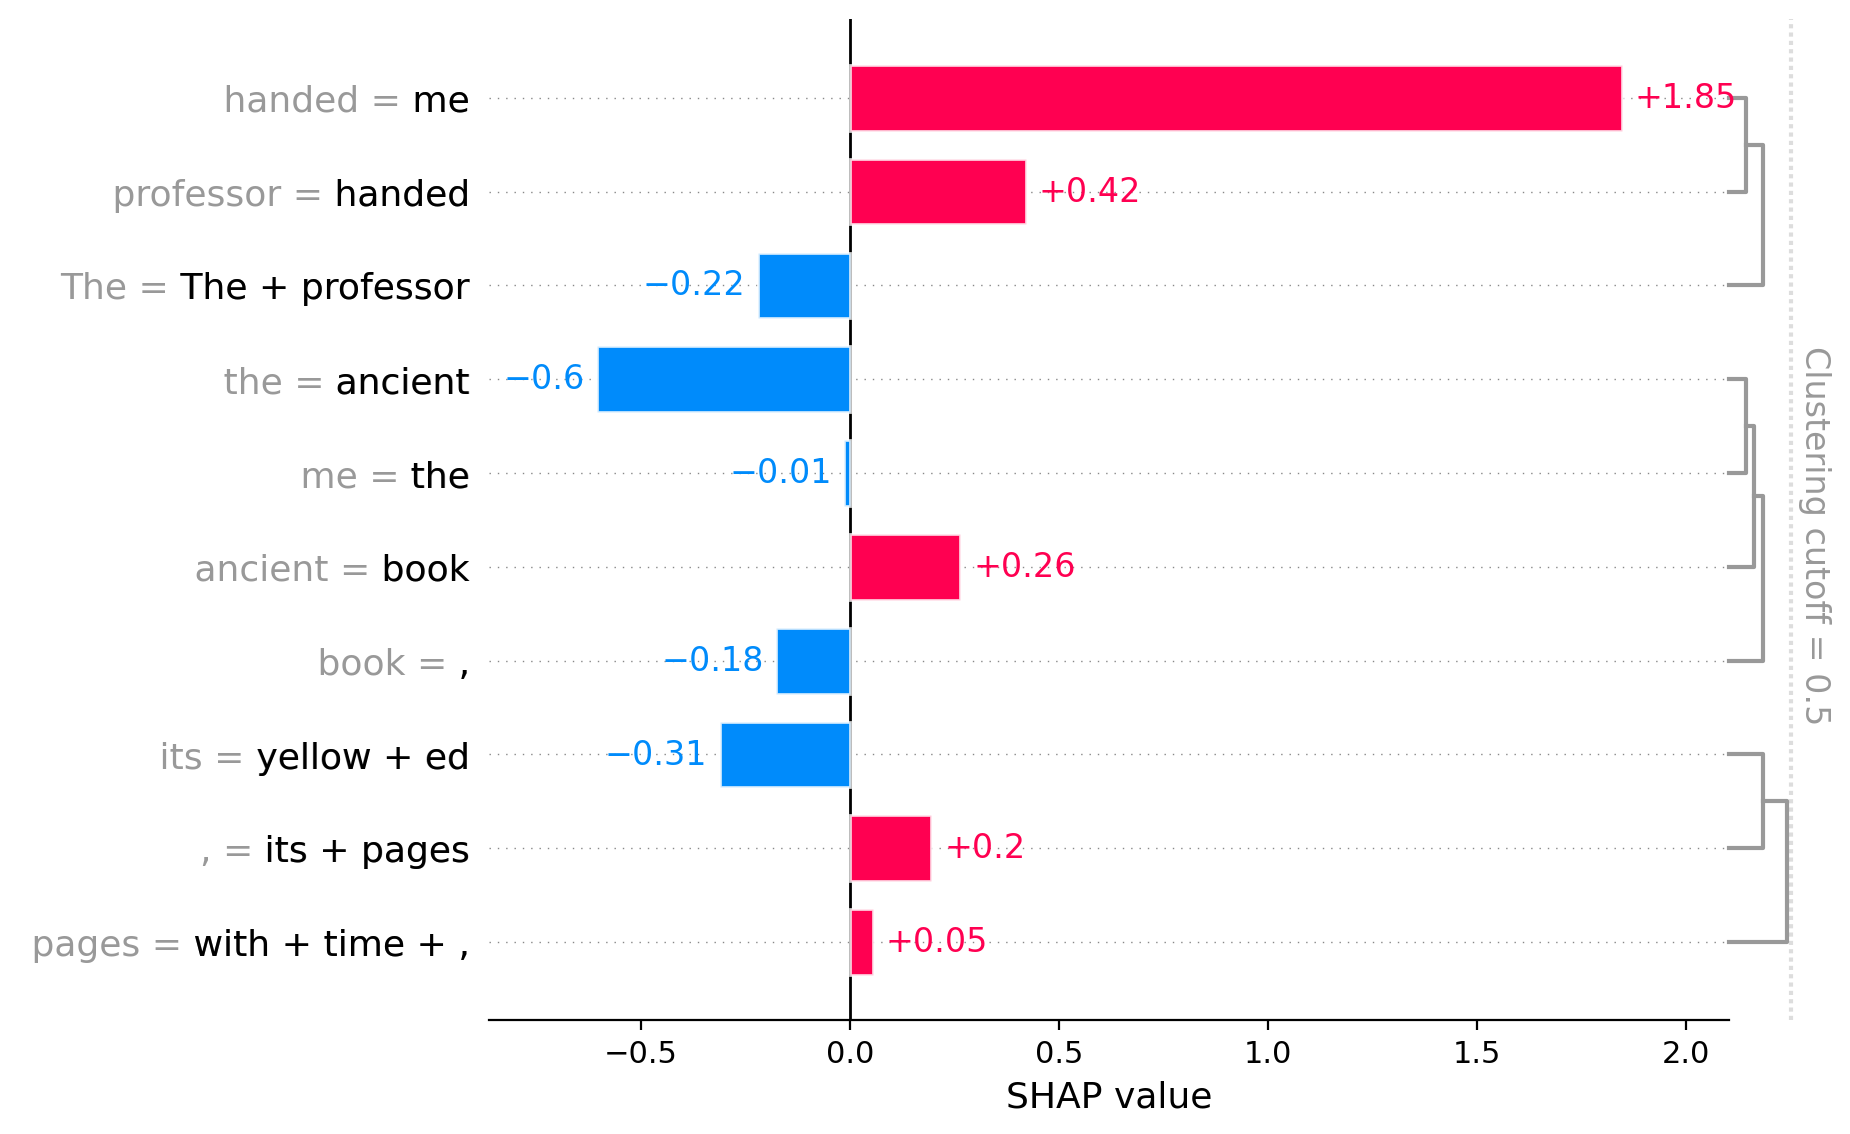

In [131]:
shap.plots.bar(shap_values[0, :,'I'])

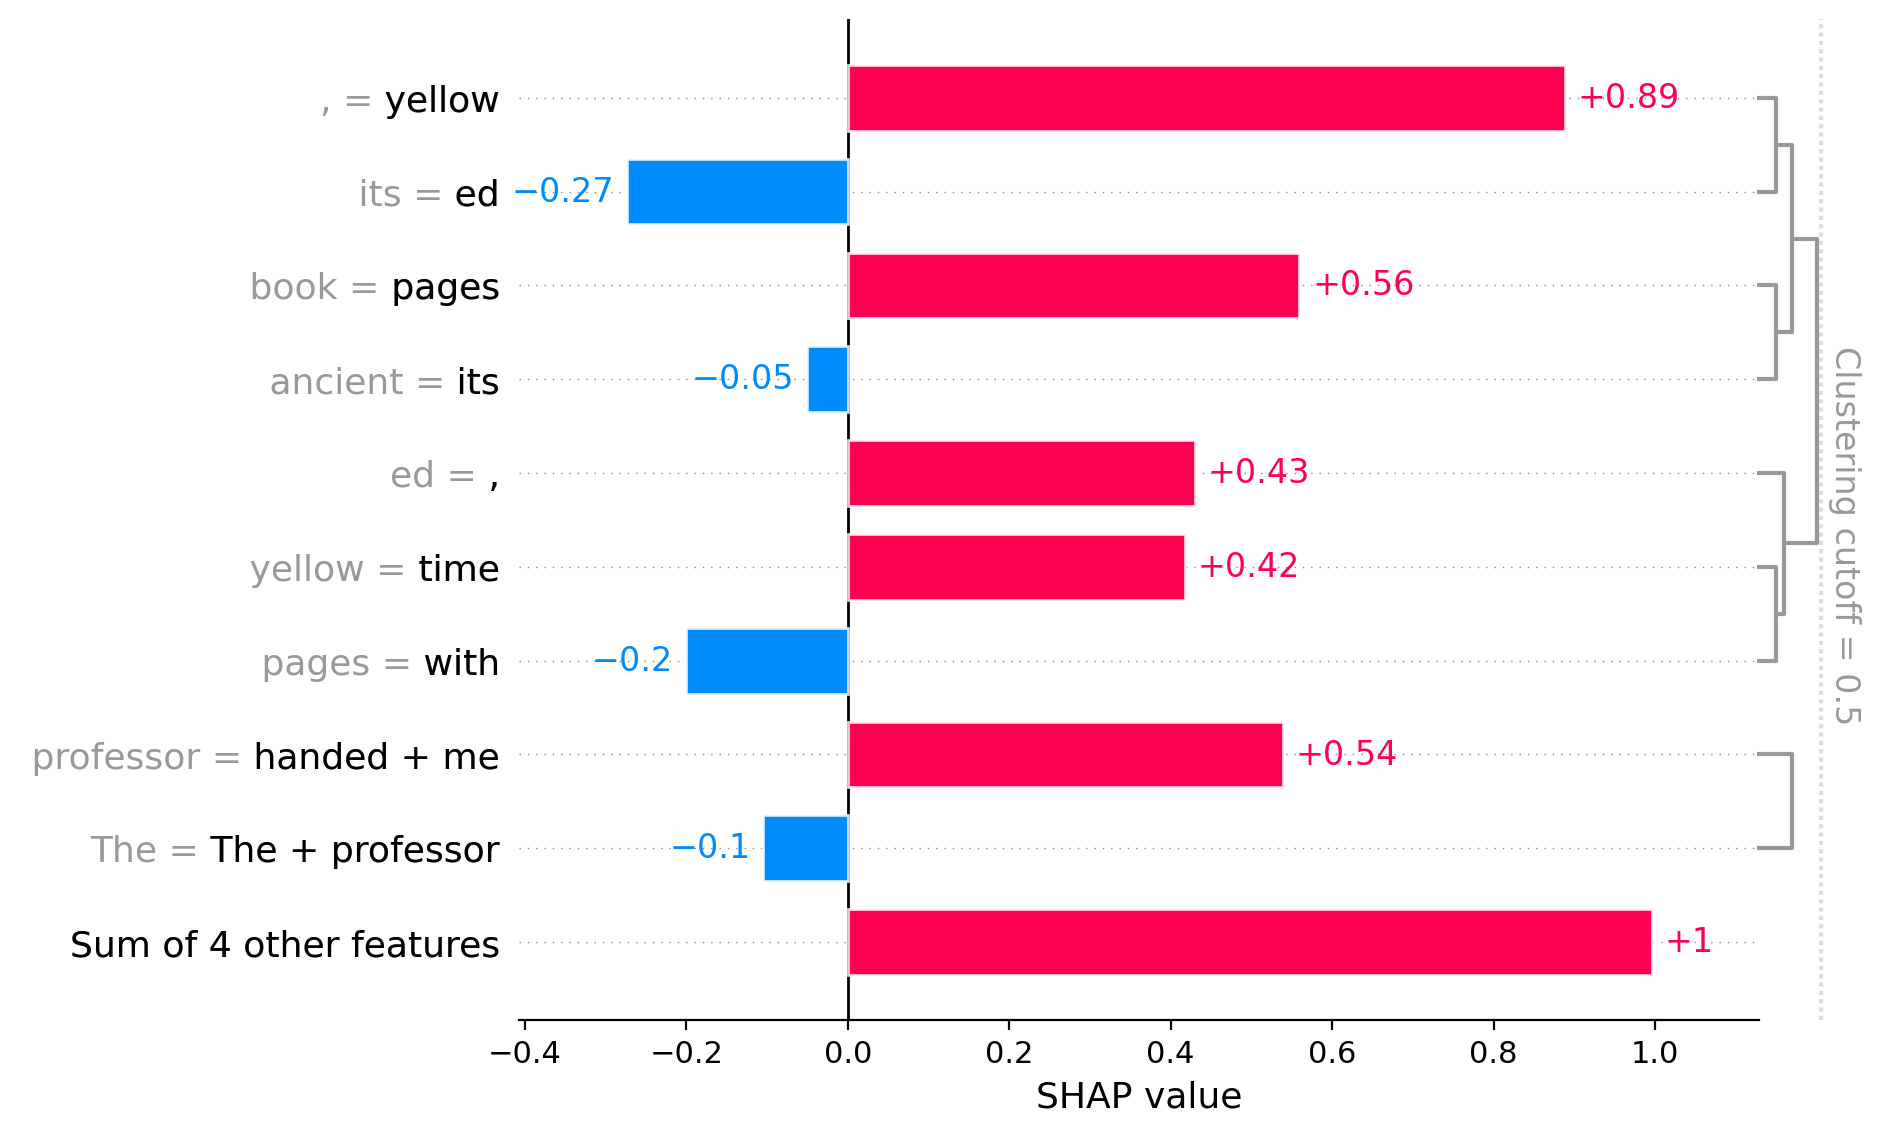

In [132]:
shap.plots.bar(shap_values[0, :,'and'])

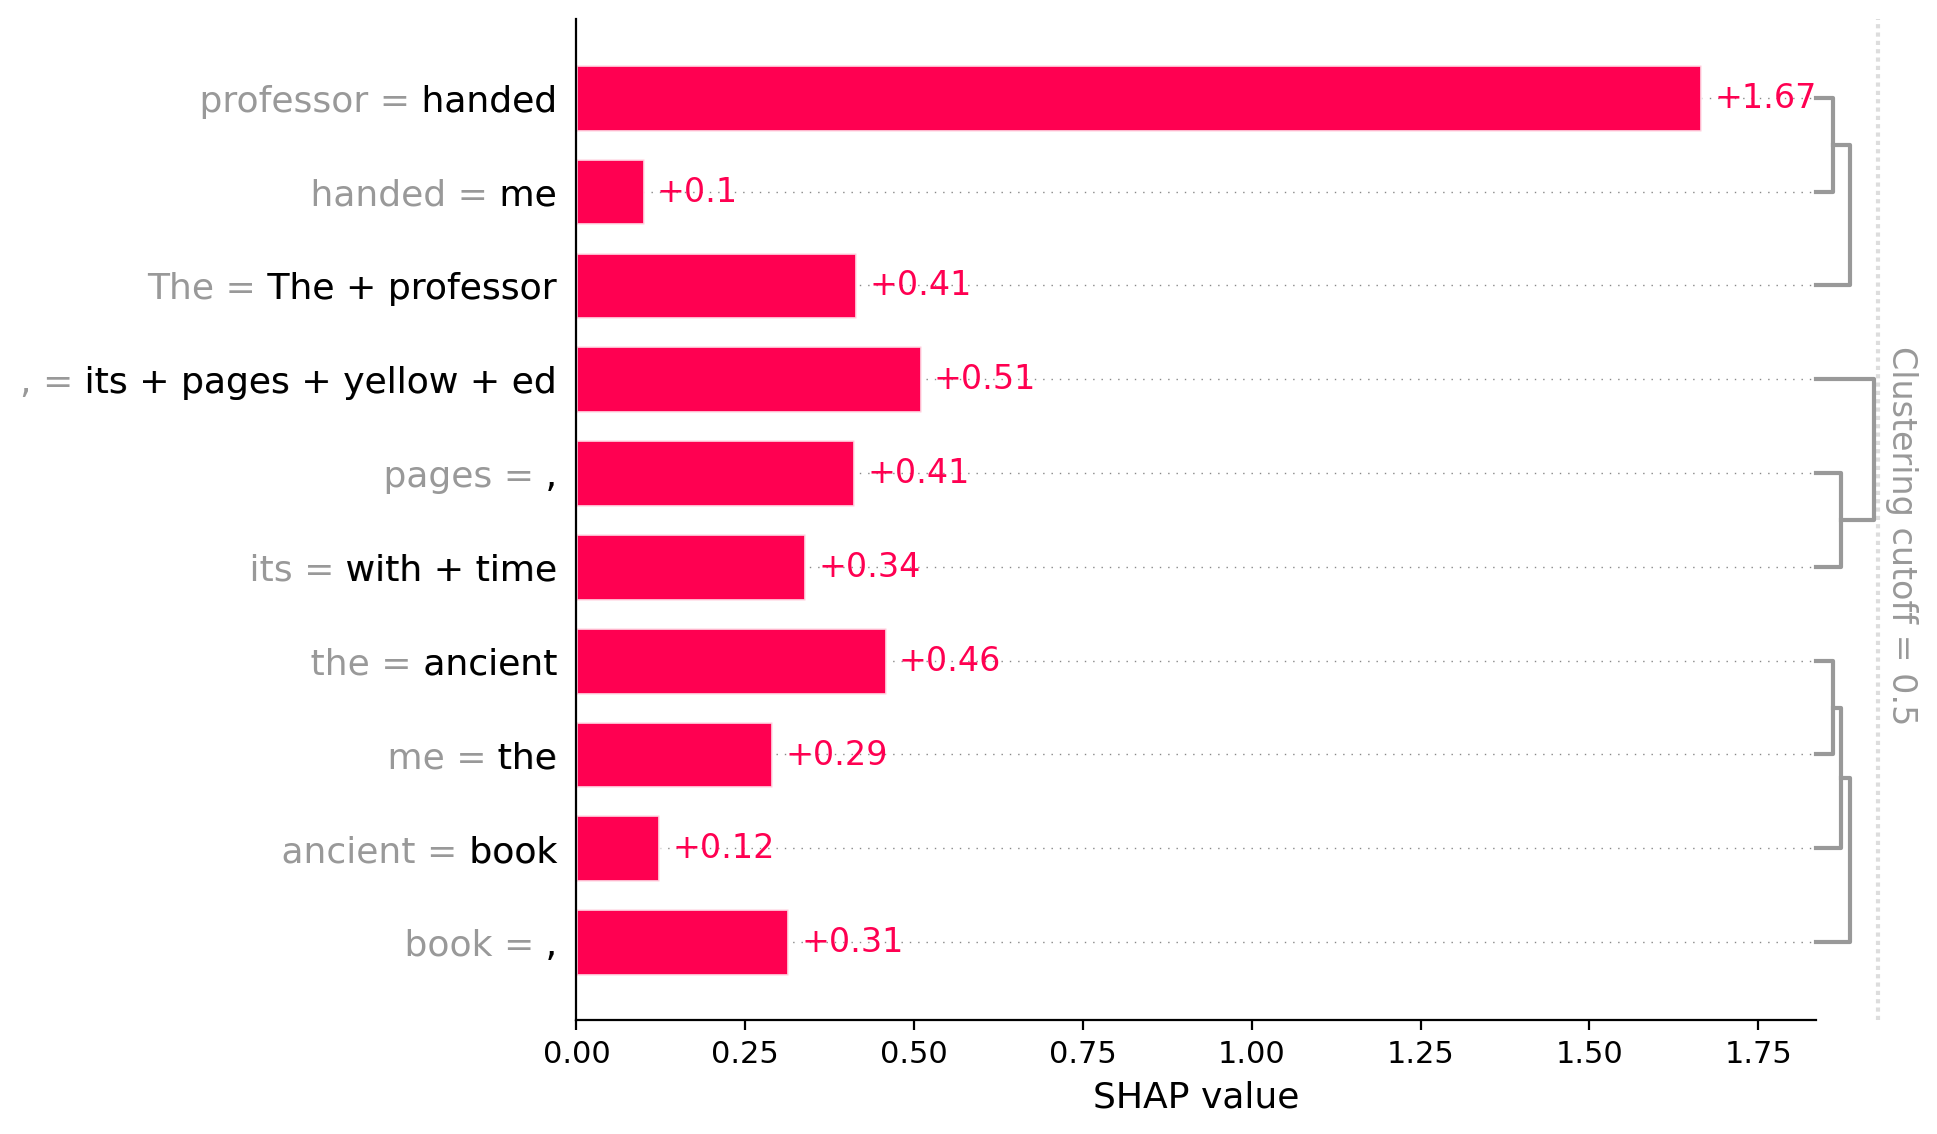

In [133]:
shap.plots.bar(shap_values[0, :,'began'])

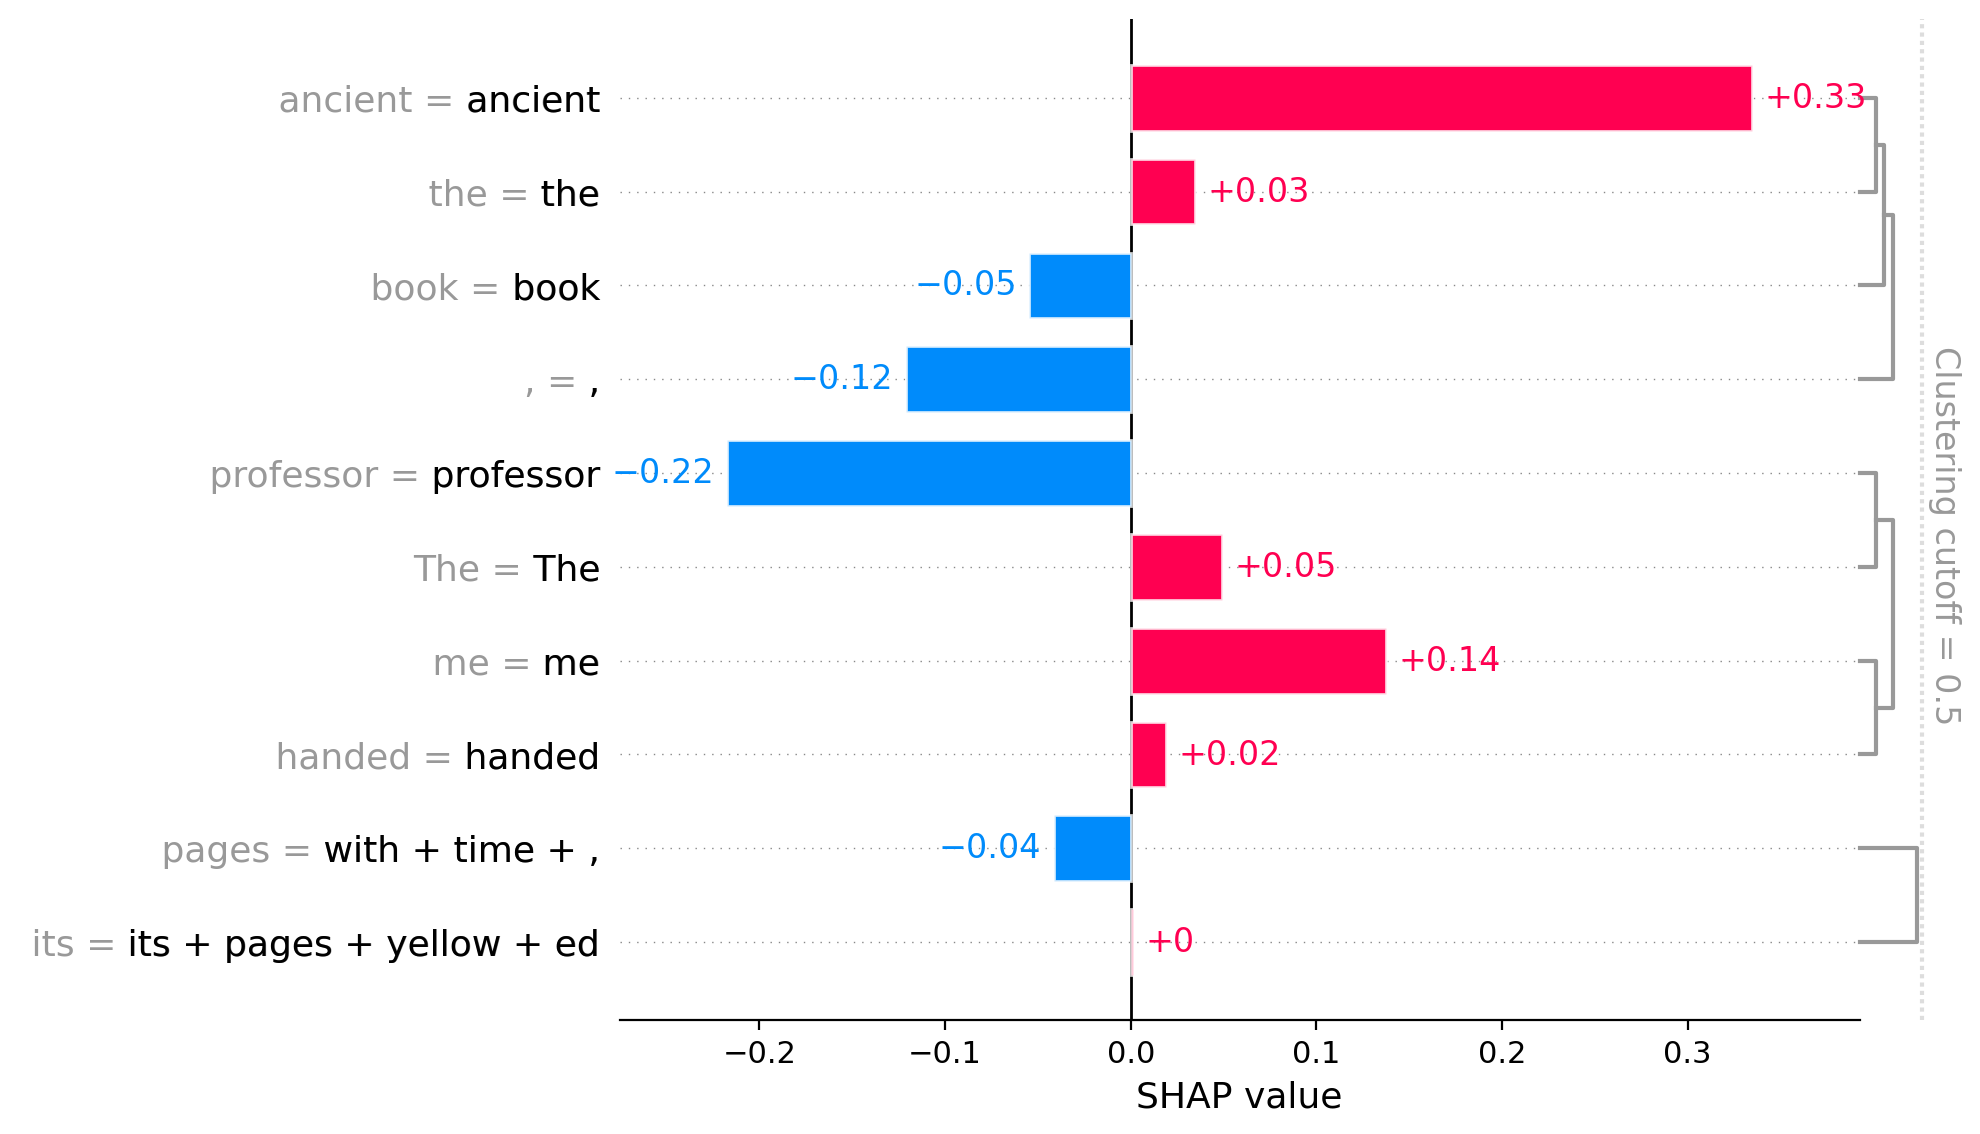

In [134]:
shap.plots.bar(shap_values[0, :,'to'])

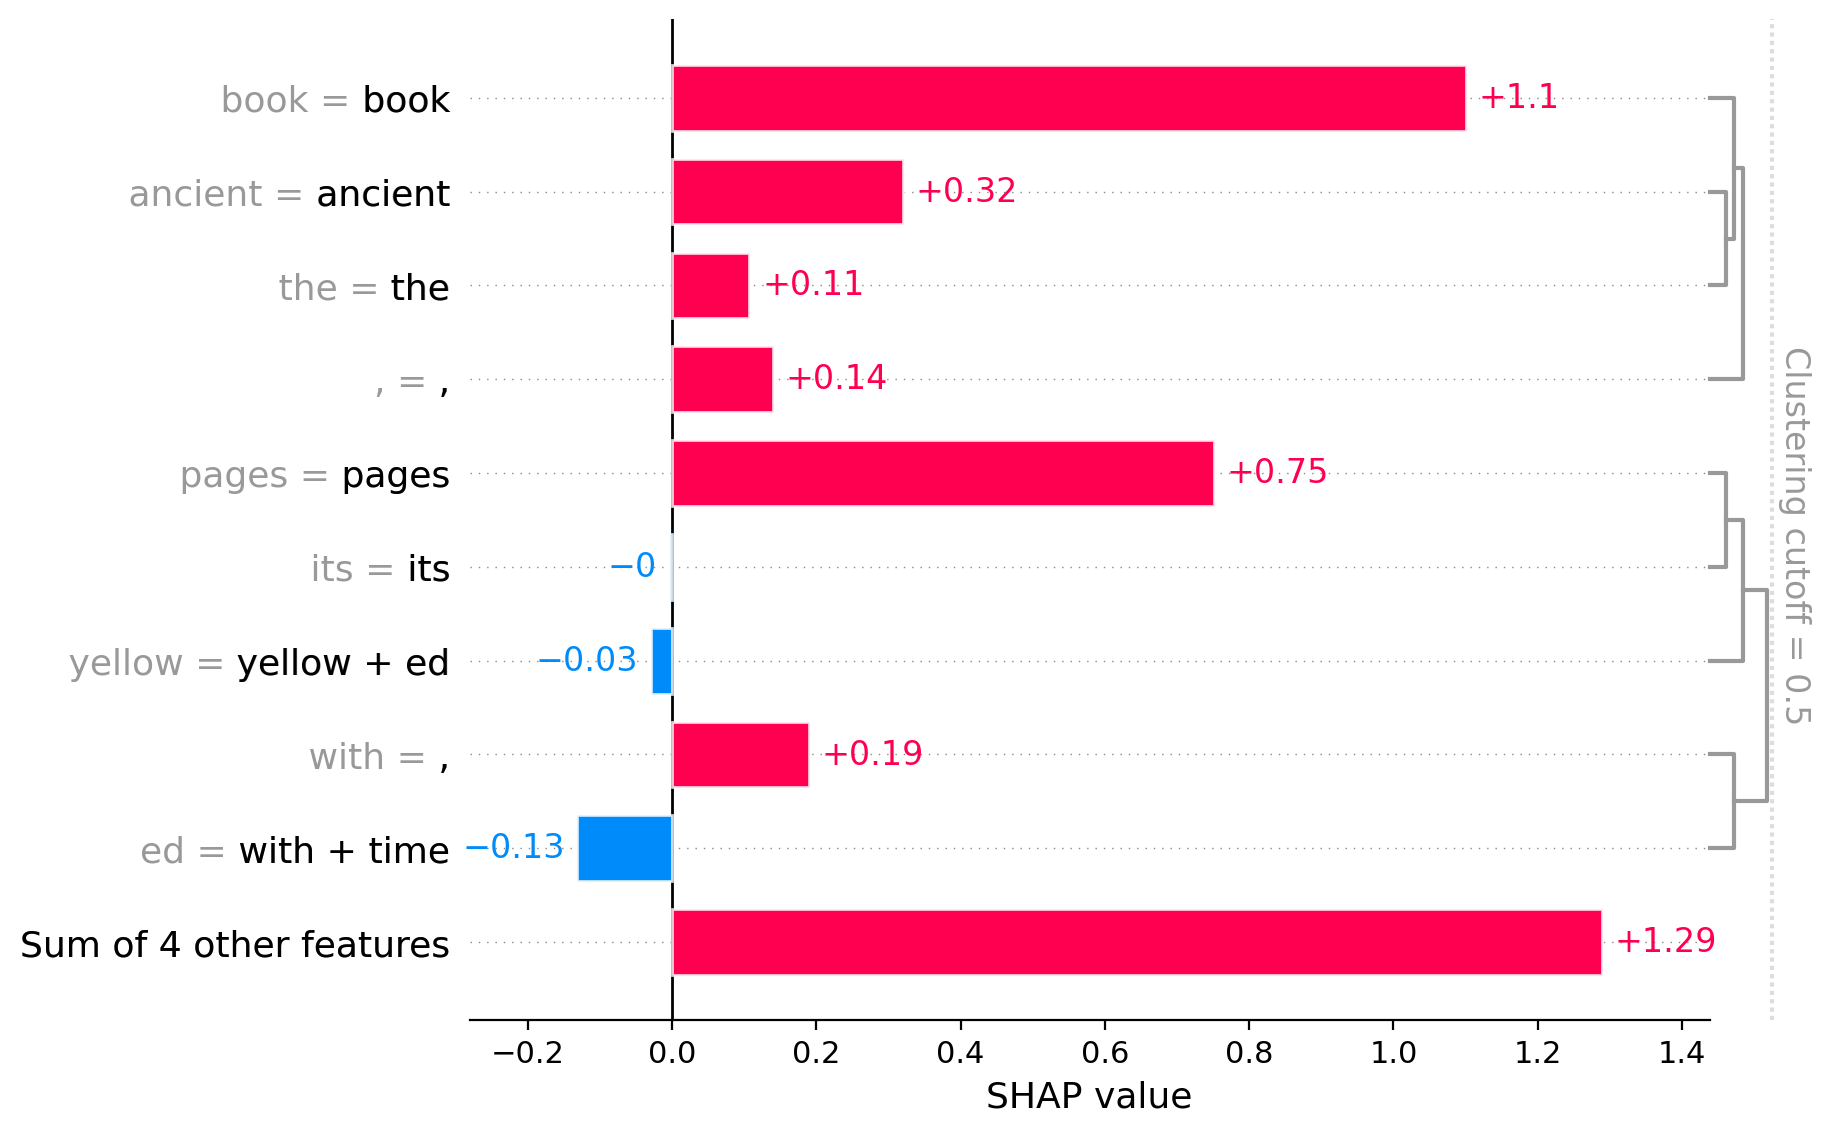

In [135]:
shap.plots.bar(shap_values[0, :,'read'])

## 3.Discussion
SHAP (SHapley Additive exPlanations) is one of the most popular techniques for explaining machine learning models, including complex models like GPT-2 used in text generation. SHAP is particularly useful for understanding which parts of an input influence a model's output, allowing us to gain insights into how different tokens (words, sub-words) in a sequence contribute to the generation of the next token or overall text.
There several reasons we want to use SHAP for GPT-2 text generation:
1. SHAP is model-agnostic, meaning it can be applied to any machine learning model, including deep neural networks like GPT-2, where the architecture (transformer-based) is often considered a "black box". It provides a unified framework for explaining both simple and complex models.
2. SHAP allows us to explain the impact of individual tokens in the input sequence on the model’s generated text. This is crucial for text generation models, where small changes in input can significantly affect the model’s predictions. For example, in GPT-2 text generation, SHAP can help us understand how specific words influence the likelihood of the next word in the sequence, giving transparency into the reasoning behind the model's output.
3. SHAP can capture interactions between tokens by assigning contributions not just to individual tokens but also to combinations of them. In text generation, words often influence one another in subtle ways, and SHAP is capable of identifying these interactions.

**Limitations**:
1. Subword-Level Analysis: GPT-2 and other transformers typically use subword tokenization (e.g., Byte Pair Encoding), which can make interpreting SHAP explanations difficult. The model might assign importance to subwords (partial words), which are harder to interpret meaningfully compared to full words.
2. Although SHAP explains the input-output relationships, it doesn't explain the internal workings of GPT-2 (such as attention patterns or how the model processes different layers). Thus, it only offers a `partial explanation` of what drives text generation in transformer models.

**Improvements**:
By developing model-specific SHAP implementations, enhancing contextual analysis, and handling subword tokenization more effectively, SHAP could become an even more powerful tool for interpreting complex language models like GPT-2.